In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#from NN_pytorch_BVP.bvp import *
#from NN_pytorch_BVP.training import *
#from NN_pytorch_BVP.formatted_table import FormattedTable

class PeriodicLayer(nn.Module):
    """
    Periodic layer recreating from the article:
    ( Sifan Wang, Shyam Sankaran ) Respecting causality is all you need for training physics-informed neural networks
    """
    def __init__(self, m: int, omega: float):
        super().__init__()
        self.m = m
        self.omega = omega

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (n, 1)
        Возвращает: ((2*m + 1)*n, 1)
        """
        n = x.shape[0]
        features = [torch.ones_like(x)]
        for k in range(1, self.m + 1):
            features.append(torch.sin(k * self.omega * x))
            features.append(torch.cos(k * self.omega * x))
        #out = torch.cat(features, dim=1)   # (n, 2*m + 1)
        #out = out.reshape(-1, 1)           # ((2*m + 1)*n, 1)
        return torch.cat(features, dim=1)
pi = torch.pi
u_exact = lambda x: torch.sin(2*pi*x + 0.25*pi) + torch.cos(9*pi*x -0.1*pi) - 2.0*torch.sin(7.0*pi*x + 0.33*pi)

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
domain = [0, 2]
n = 100
m = 3
n_epochs = 1000

device = 'cuda'
torch.manual_seed(2008)
model = nn.Sequential(
    PeriodicLayer(m, torch.pi), nn.Tanh(), 
    nn.Linear(2*m + 1, 128), nn.Tanh(), 
    nn.Linear(128,128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)
for k in range(1, n_epochs + 1):
    x = (domain[1] - domain[0]) * torch.rand(n, 1, device=device) + domain[0]
    u = model(x)
    optimizer.zero_grad()
    tmp = torch.mean( (u - u_exact(x))**2 )
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()
    if k == 1 or k % 100 == 0:
        print(f"epoch = {k:6d}, loss = {loss[k-1]:10.4e}")


epoch =      1, loss = 2.7523e+00
epoch =    100, loss = 2.1889e+00
epoch =    200, loss = 2.2013e+00
epoch =    300, loss = 2.6479e-01
epoch =    400, loss = 1.4794e-02
epoch =    500, loss = 5.4916e-03
epoch =    600, loss = 3.8387e-03
epoch =    700, loss = 1.8662e-03
epoch =    800, loss = 8.6811e-04
epoch =    900, loss = 6.4019e-04
epoch =   1000, loss = 6.4786e-04


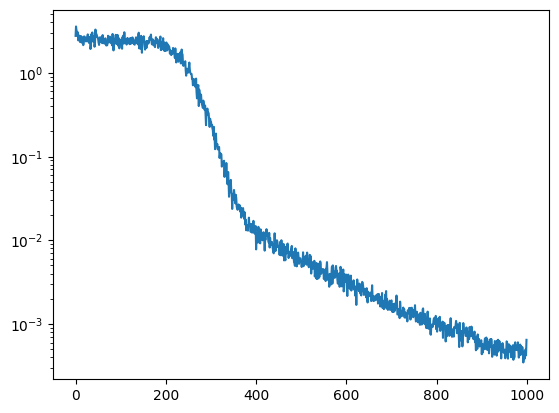

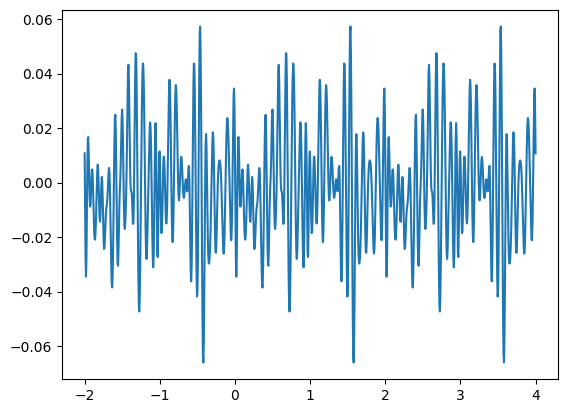

In [2]:
plt.semilogy(loss.detach().cpu())
plt.show()

model = model.to("cpu")
x = torch.linspace(*[-2, 4], 1000).reshape(-1, 1)
plt.plot(x, model(x).detach().cpu() - u_exact(x))
plt.show()